# Fundamentos de analítica 2 (clase 1)

## Diego Fernando Agudelo 
## Universidad ICESI 
## diegoagudelo30@gmail.com


## **1. Carga de paquetes**

In [1]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos 
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error


Este documento presenta una breve introducción a la construcción de objetos de series de tiempo y el cálculo de pronósticos con modelos de suavización.

Para este ejercicio emplearemos la información disponible en el archivo datosEmpleo.xlsx. En ese archivo econtrarán la tasa de desempleo mensual de las 13 principales ciudades en Colombia (TD_13ciudades). El archivo también contiene series mensuales para las 13 principales ciudades de Colombia el número de ocupados en miles de personas (Ocupados), los desocupados (Desocupados) y los inactivos (Inactivos).

## **2. Carga de datos**

Nuestra primera tarea será leer el archivo de Excel. Para eso podemos emplear el paquete Pandas. Carguemos los datos en un objeto que denominaremos data.

In [2]:
data = pd.read_excel("datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


En este caso los datos fueron leídos como un data frame y adicionalmente la columna "mes" fue seleccionada como indice, con el dataframe de esta forma sera más facil trabajar las series de tiempo.

A continuación se gráfica el Total de Ocupados.



(220, 4)


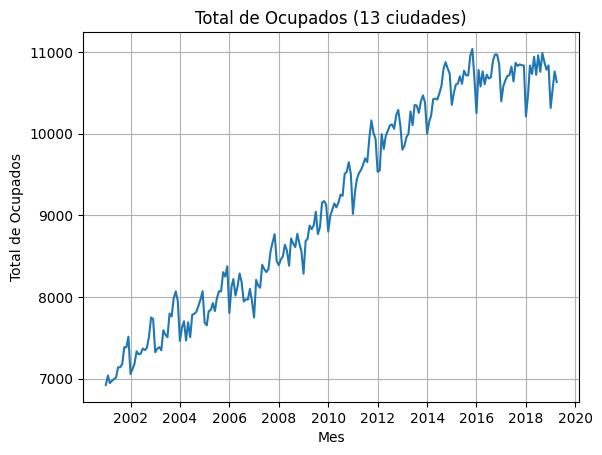

In [3]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos
plt.title("Total de Ocupados (13 ciudades)")
plt.xlabel("Mes")
plt.ylabel("Total de Ocupados")
plt.plot(data[["Ocupados"]])
plt.grid()
plt.show()

## **3. Encontrando los componentes de una serie de tiempo**

En algunas ocasiones puede ser útil empezar nuestro análisis descomponiendo la serie de tiempo en sus componentes: **tendencia**, **estacionalidad** y **componente puramente aleatorio**. Una forma de hacer esto es empleando la función seasonal_decompose. 

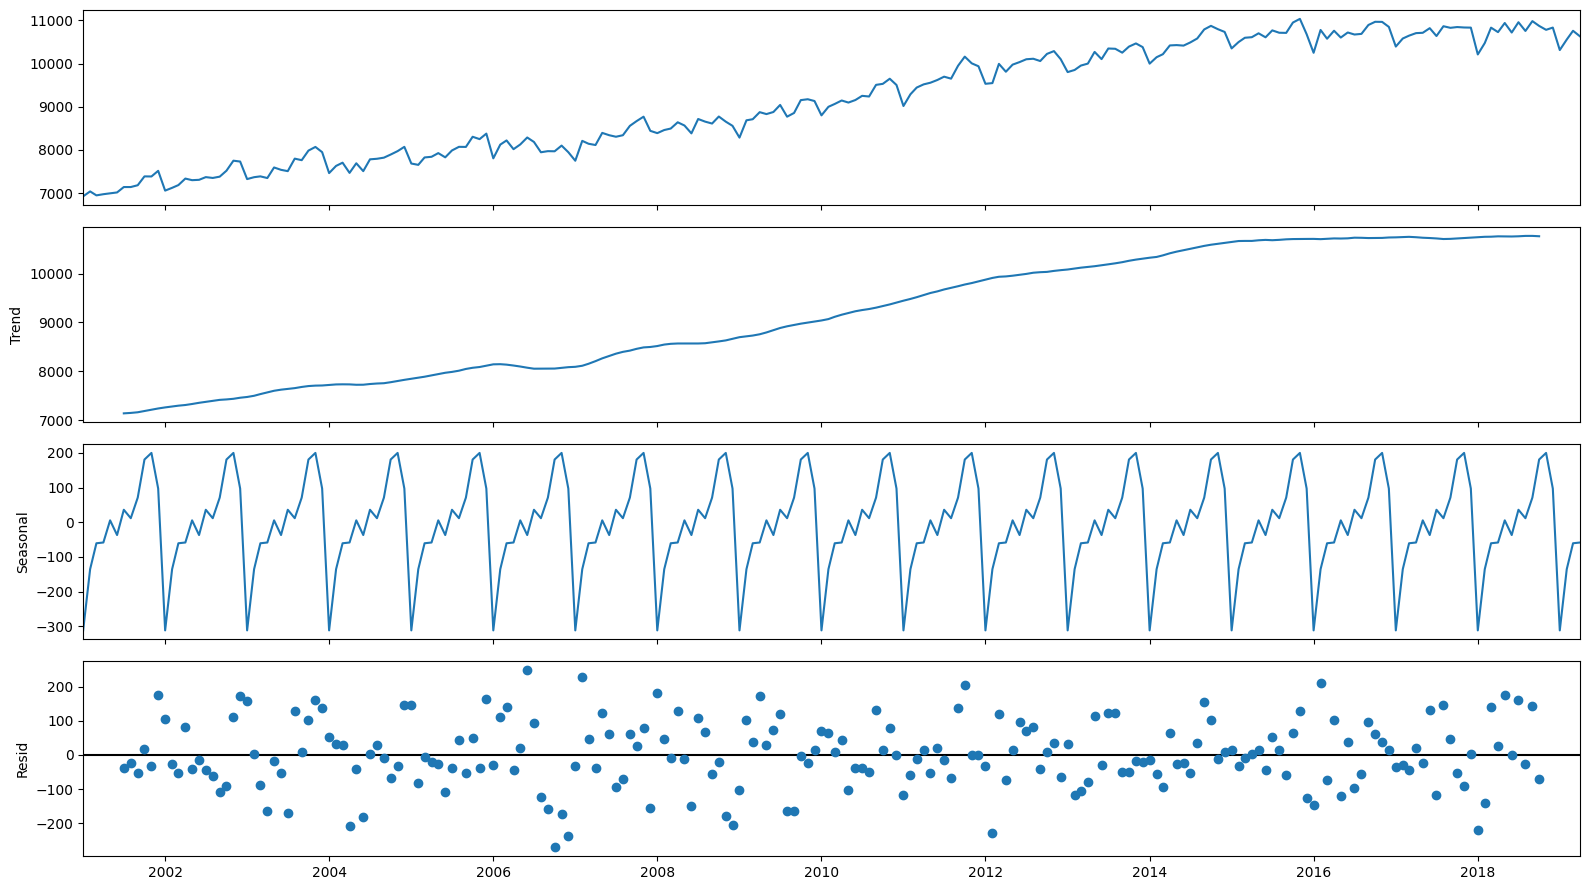

In [4]:
Ocupados_componentes = seasonal_decompose(data[["Ocupados"]],model="additive")
fig = Ocupados_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

Asi se extrae cada elemento de la descomposición de la serie.

In [5]:
Ocupados_componentes.seasonal


mes
2001-01-01   -311.454885
2001-02-01   -135.216366
2001-03-01    -60.470657
2001-04-01    -58.270721
2001-05-01      5.551095
                 ...    
2018-12-01     97.140345
2019-01-01   -311.454885
2019-02-01   -135.216366
2019-03-01    -60.470657
2019-04-01    -58.270721
Name: seasonal, Length: 220, dtype: float64

Podemos observar el componente estacional marcado en la serie, una tendencia no lineal de los datos y la parte aleatoria.

Es importante mencionar que esta descomposición se emplea solo como referencia para iniciar el análisis.

Antes de entrar a trabajar con los métodos de suavizamiento, vale la pena anotar que una forma sencilla y rápida para quitar el componente estacional (desestacionalizar) es restarle a la serie el componente estacional encontrado en la descomposición. Es decir,

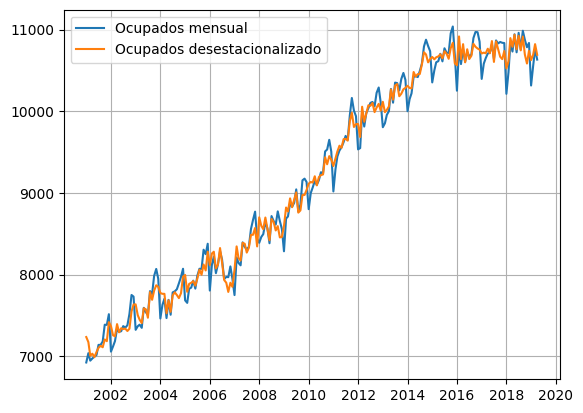

In [6]:
Ocupados_desestacionalizada = data["Ocupados"]-Ocupados_componentes.seasonal

plt.plot(data[["Ocupados"]],label="Ocupados mensual")
plt.plot(Ocupados_desestacionalizada,label="Ocupados desestacionalizado")
plt.legend()
plt.grid()
plt.show()


## **4. Pronosticando metodos de suavización**

Antes de continuar es importante guardar una parte de la muestra para evaluar el comportamiento de los modelos por fuera de muestra (out-of-sample). Guardemos seis meses. 

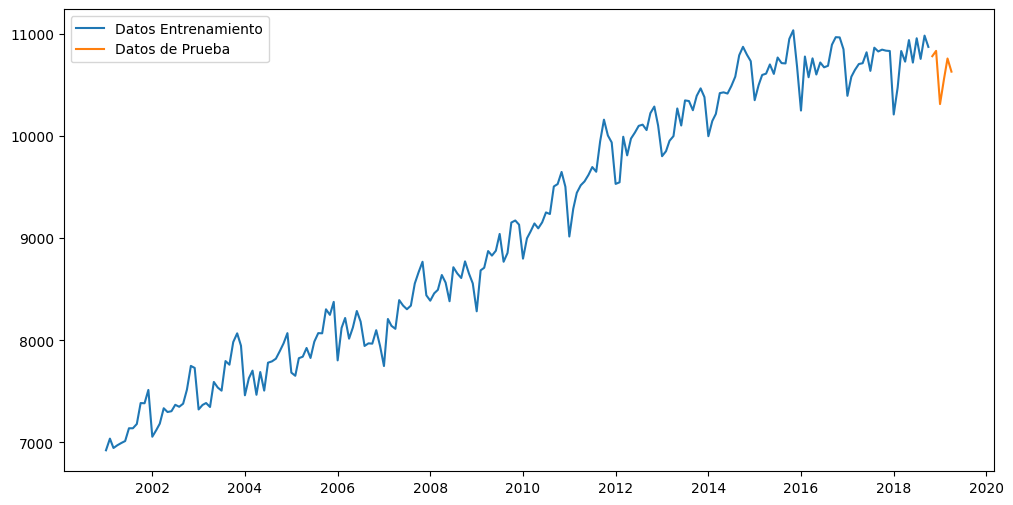

In [7]:
train_len = 208 + 6
train_Ocupados = data[["Ocupados"]][:train_len]
test_Ocupados = data[["Ocupados"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_Ocupados,label="Datos Entrenamiento")
plt.plot(test_Ocupados,label="Datos de Prueba")
plt.legend()
plt.show()

In [8]:
train_Ocupados

,Ocupados
mes,
2001-01-01,6923.604
2001-02-01,7037.746
2001-03-01,6945.973
2001-04-01,6973.079
2001-05-01,6994.462
...,...
2018-06-01,10720.946
2018-07-01,10959.197
2018-08-01,10756.782


In [9]:
test_Ocupados

,Ocupados
mes,
2018-11-01,10783.299
2018-12-01,10835.398
2019-01-01,10314.438
2019-02-01,10557.917
2019-03-01,10760.776
2019-04-01,10632.028


### **4.1 Promedio movil**

El promedio móvil está dado por:

$$ F_{t + 1}=\frac{Y_{t} + Y_{t-1} + Y_{t-(k-1)} }{ k} $$

El método de los promedios móviles utiliza el promedio de los $k$
valores de datos más recientes en la serie de tiempo como el
pronóstico para el siguiente periodo.

El término móvil indica que, mientras se dispone de una nueva
observación para la serie de tiempo, reemplaza a la observación más
antigua de la ecuación anterior y se calcula un promedio nuevo.
Como resultado, el promedio cambiará, o se moverá, conforme surjan
nuevas observaciones.

$Y_{t}$ = Observación en el período t

$F_{t}$ = Pronóstico en el período t

In [10]:
## Considerando el dato actual
ma_2= train_Ocupados.rolling(2,min_periods=2).mean()
ma_3= train_Ocupados.rolling(3,min_periods=2).mean()
ma_4= train_Ocupados.rolling(4,min_periods=2).mean()
ma_5= train_Ocupados.rolling(5,min_periods=2).mean()

In [11]:
## Sin considerar el dato actual
ma_2= train_Ocupados.shift().rolling(2,min_periods=2).mean()
ma_3= train_Ocupados.shift().rolling(3,min_periods=2).mean()
ma_4= train_Ocupados.shift().rolling(4,min_periods=2).mean()
ma_5= train_Ocupados.shift().rolling(5,min_periods=2).mean()


In [12]:
def fore_ma(datos,w,h):
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
  return data[-h:] 

In [13]:
ma_2_f= fore_ma(train_Ocupados,2,6)
ma_3_f= fore_ma(train_Ocupados,3,6)
ma_4_f= fore_ma(train_Ocupados,4,6)
ma_5_f= fore_ma(train_Ocupados,5,6)

In [14]:
rmse_ma_2 = np.sqrt(mean_squared_error(test_Ocupados,ma_2_f ))
rmse_ma_3 = np.sqrt(mean_squared_error(test_Ocupados,ma_3_f ))
rmse_ma_4 = np.sqrt(mean_squared_error(test_Ocupados,ma_4_f ))
rmse_ma_5 = np.sqrt(mean_squared_error(test_Ocupados,ma_5_f ))

In [15]:
print( rmse_ma_2, rmse_ma_3 ,rmse_ma_4 ,rmse_ma_5)

319.1849777906289 298.3770292088787 305.34686253059 291.01606293356485


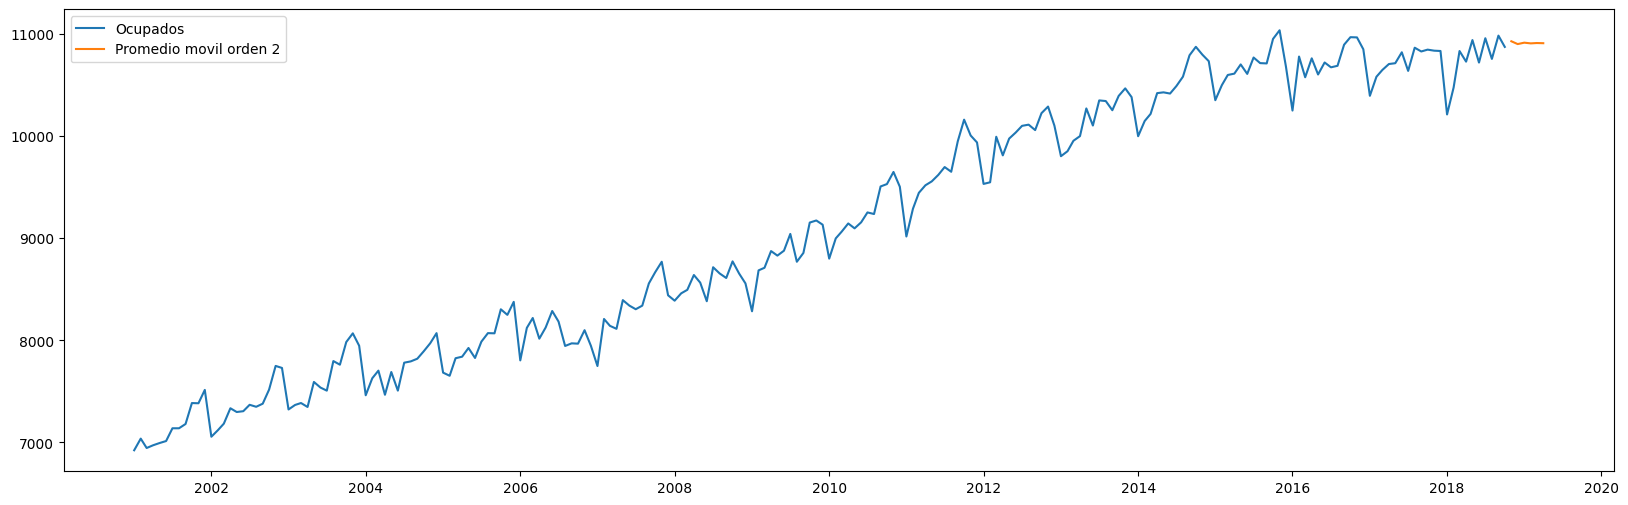

In [16]:
fig = plt.figure(figsize=(20, 6))
plt.plot(train_Ocupados,label="Ocupados")
plt.plot(ma_2_f,label="Promedio movil orden 2")
plt.legend()
plt.show()

## **5. Ejercicio en Clase**

Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses. Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [24]:
def calculo(train, tipo, i_error, i_trend, i_seasonal):
  #print( f"Procesando:  Tipo :{tipo} Error: {i_error} Trend: {i_trend} Seasonal: {i_seasonal}" )

  cadena = "|{:<10}|{:<10}|{:<10}|{:<10}|".format(tipo, i_error, i_trend, i_seasonal)
  print(cadena)
  print("+----------+----------+----------+----------+")


  # Build model.
  if i_seasonal == "None":
    if i_trend == "None":
      ets_model = ETSModel(endog=train["Ocupados"],error=i_error)
    elif i_error == "None":
      ets_model = ETSModel(endog=train["Ocupados"],trend=i_trend)
    else:
      ets_model = ETSModel(endog=train["Ocupados"],error=i_error,trend=i_trend)
  elif i_trend == "None":
    if i_error == "None":
      ets_model = ETSModel(endog=train["Ocupados"],seasonal=i_seasonal)
    else:
      ets_model = ETSModel(endog=train["Ocupados"],error=i_error,seasonal=i_seasonal)
  elif i_error == "None":
    ets_model = ETSModel(endog=train["Ocupados"],trend=i_trend,seasonal=i_seasonal)
  else:
    ets_model = ETSModel(endog=train["Ocupados"],error=i_error,trend=i_trend,seasonal=i_seasonal)
    
  ets_result = ets_model.fit()

  point_forecast=ets_result.forecast(6)

  ci = ets_result.get_prediction(start = point_forecast.index[0],
                                  end = point_forecast.index[-1])

  conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
  limits = ci.predicted_mean


  preds_hw_mul = pd.concat([limits, conf_forecast], axis = 1)
  preds_hw_mul.columns = ['Point_forecast', 'lower_95', 'upper_95']
  #print(preds_hw_mul)

  lv_label =  tipo + ": Error: " + i_error + "Trend: " + i_trend + "Seasonal: " i_seasonal	

  fig = plt.figure(figsize=(12, 6))
  plt.plot(train,label="Datos Entrenamiento")
  plt.plot(preds_hw_mul['Point_forecast'],label=lv_label)
  plt.fill_between(preds_hw_mul.index ,preds_hw_mul['lower_95'], preds_hw_mul['upper_95'], color='blue', alpha=0.1)
  plt.legend()
  plt.show()

  e_Alpha = ''
  e_Beta  = '' 
  E_Gamma = ''

  #print("Alpha:  ", ets_result.alpha)
  e_Alpha = ets_result.alpha
  
  if i_trend != "None":
  #  print("Beta:  ", ets_result.beta)
    e_Beta = ets_result.beta    
  if i_seasonal != "None":
  #  print("Gamma: ", ets_result.gamma)
    E_Gamma = ets_result.gamma
    
  rmse_hw_mul = np.sqrt(mean_squared_error(test_Ocupados,preds_hw_mul['Point_forecast']))
  #print("RSME", rmse_hw_mul)
  
  return( e_Alpha, e_Beta, E_Gamma , rmse_hw_mul )

In [25]:

Options_Array = [['Winters', 'Add', 'Add', 'Add', '', '', '', ''],
    ['Winters', 'Add', 'Add', 'Mul', '', '', '', ''],
    ['Holt', 'Add', 'Add', 'None', '', '', '', ''],
    ['Winters', 'Add', 'Mul', 'Add', '', '', '', ''],
    ['Winters', 'Add', 'Mul', 'Mul', '', '', '', ''],
    ['Holt', 'Add', 'Mul', 'None', '', '', '', ''],
    ['Winters', 'Add', 'None', 'Add', '', '', '', ''],
    ['Winters', 'Add', 'None', 'Mul', '', '', '', ''],
    ['Simple', 'Add', 'None', 'None', '', '', '', ''],
    ['Winters', 'Mul', 'Add', 'Add', '', '', '', ''],
    ['Winters', 'Mul', 'Add', 'Mul', '', '', '', ''],
    ['Holt', 'Mul', 'Add', 'None', '', '', '', ''],
    ['Winters', 'Mul', 'Mul', 'Add', '', '', '', ''],
    ['Winters', 'Mul', 'Mul', 'Mul', '', '', '', ''],
    ['Holt', 'Mul', 'Mul', 'None', '', '', '', ''],
    ['Winters', 'Mul', 'None', 'Add', '', '', '', ''],
    ['Winters', 'Mul', 'None', 'Mul', '', '', '', ''],
    ['Simple', 'Mul', 'None', 'None', '', '', '', ''],
    ['Winters', 'None', 'Add', 'Add', '', '', '', ''],
    ['Winters', 'None', 'Add', 'Mul', '', '', '', ''],
    ['Holt', 'None', 'Add', 'None', '', '', '', ''],
    ['Winters', 'None', 'Mul', 'Add', '', '', '', ''],
    ['Winters', 'None', 'Mul', 'Mul', '', '', '', ''],
    ['Holt', 'None', 'Mul', 'None', '', '', '', ''],
    ['Winters', 'None', 'None', 'Add', '', '', '', ''],
    ['Winters', 'None', 'None', 'Mul', '', '', '', '']]

df = pd.DataFrame(Options_Array, columns=['Tipo', 'Error', 'Trend', 'Seasonal', 'Alpha', 'Beta', 'Gamma', 'RMSE'])

In [26]:
df.head()

,Tipo,Error,Trend,Seasonal,Alpha,Beta,Gamma,RMSE
0,Winters,Add,Add,Add,,,,
1,Winters,Add,Add,Mul,,,,
2,Holt,Add,Add,None,,,,
3,Winters,Add,Mul,Add,,,,
4,Winters,Add,Mul,Mul,,,,


Procesando...
+----------+----------+----------+----------+
+ Tipo     + Error    + Tred     + Seasonal +
+----------+----------+----------+----------+
|Winters   |Add       |Add       |Add       |
+----------+----------+----------+----------+


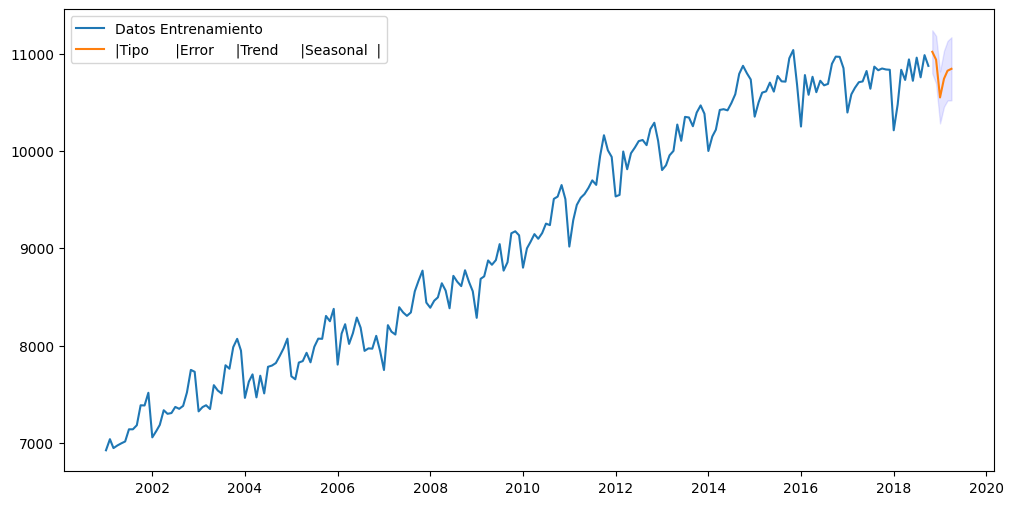

|Winters   |Add       |Add       |Mul       |
+----------+----------+----------+----------+


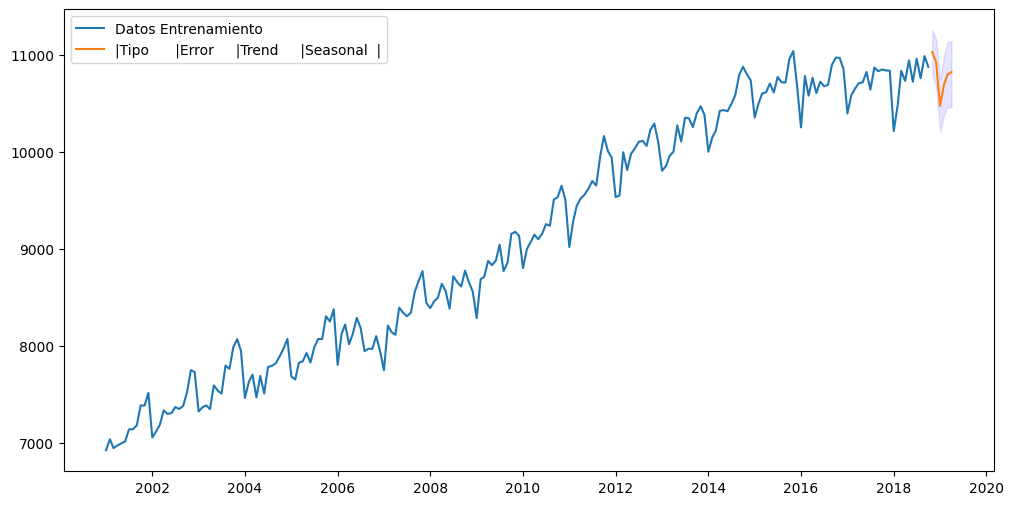

|Holt      |Add       |Add       |None      |
+----------+----------+----------+----------+


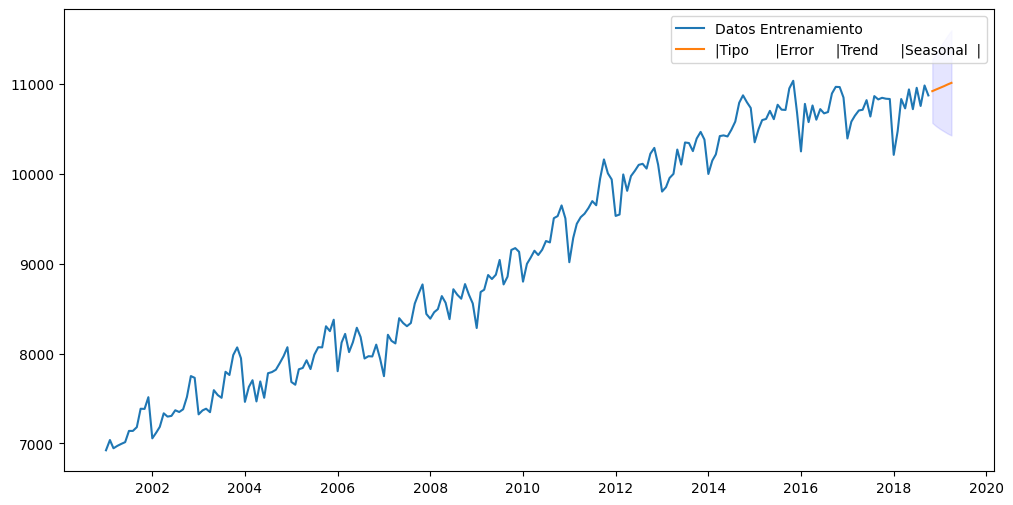

|Winters   |Add       |Mul       |Add       |
+----------+----------+----------+----------+


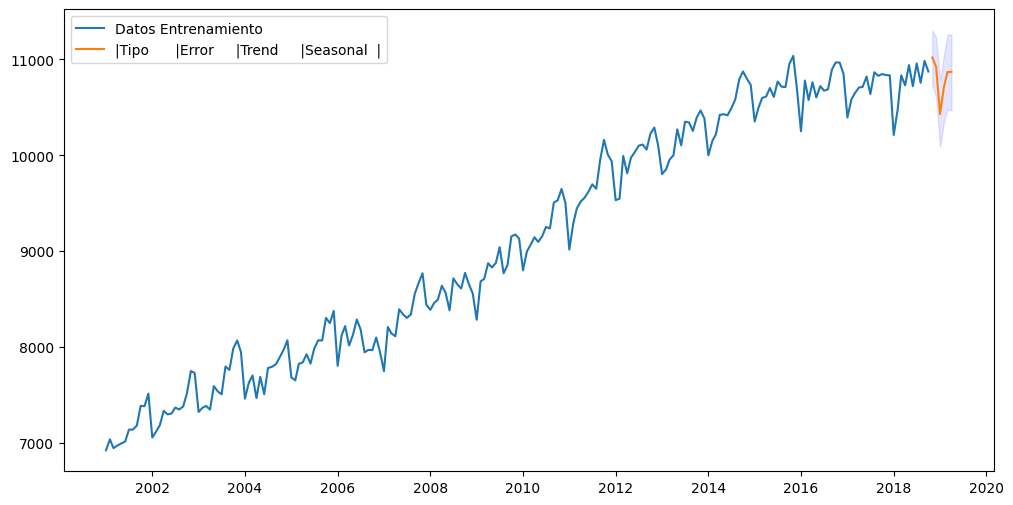

|Winters   |Add       |Mul       |Mul       |
+----------+----------+----------+----------+


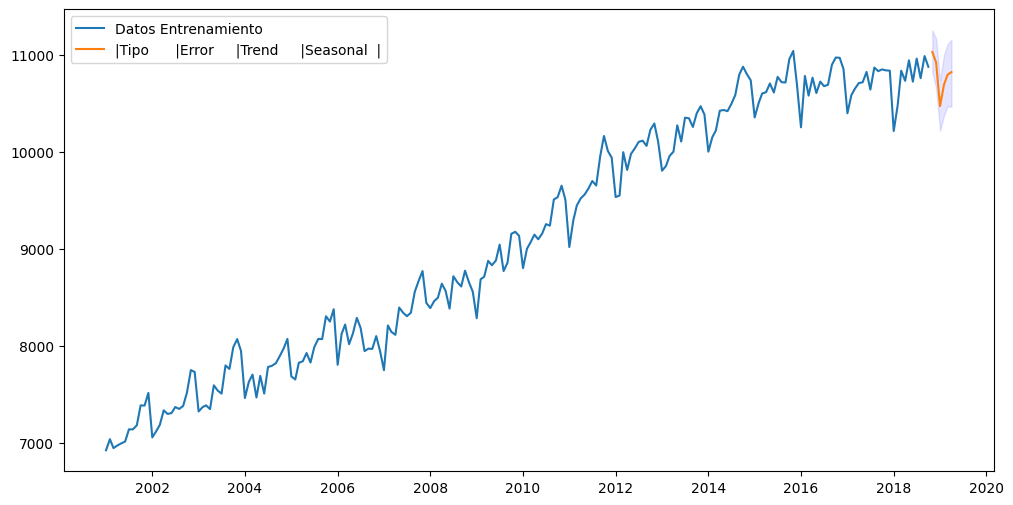

|Holt      |Add       |Mul       |None      |
+----------+----------+----------+----------+


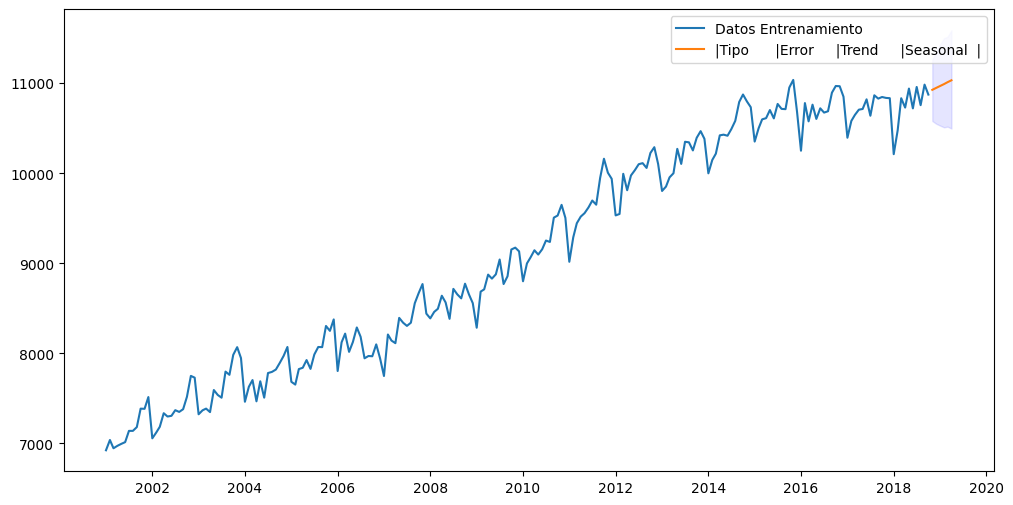

|Winters   |Add       |None      |Add       |
+----------+----------+----------+----------+


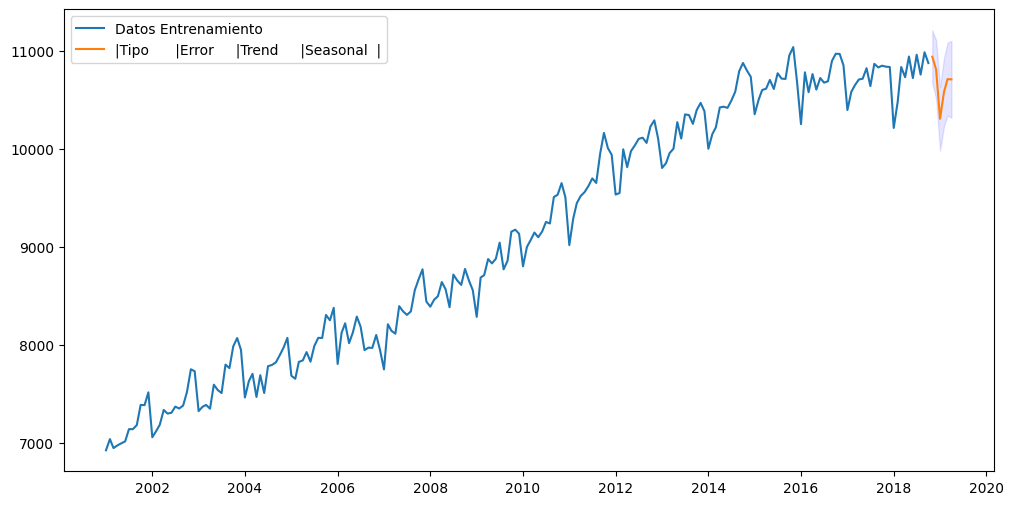

|Winters   |Add       |None      |Mul       |
+----------+----------+----------+----------+


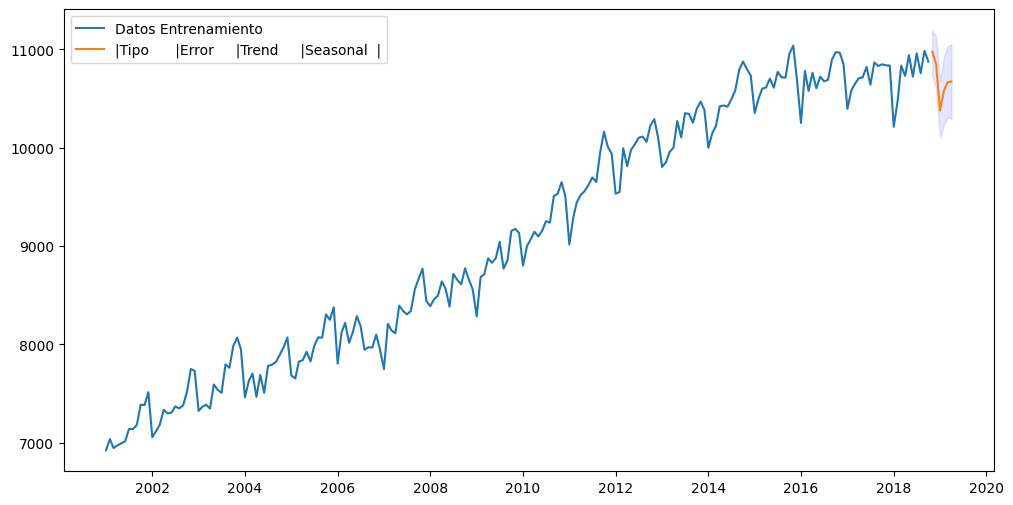

|Simple    |Add       |None      |None      |
+----------+----------+----------+----------+


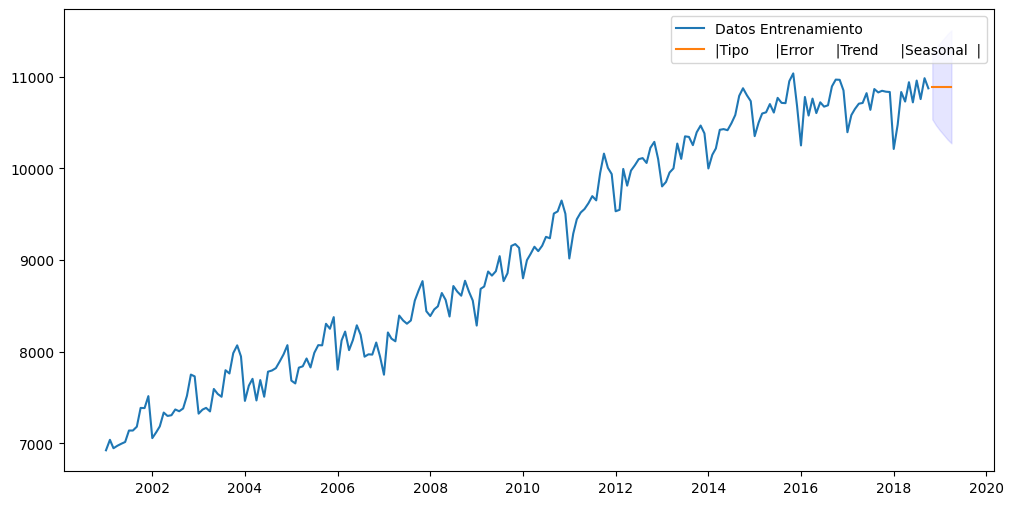

|Winters   |Mul       |Add       |Add       |
+----------+----------+----------+----------+


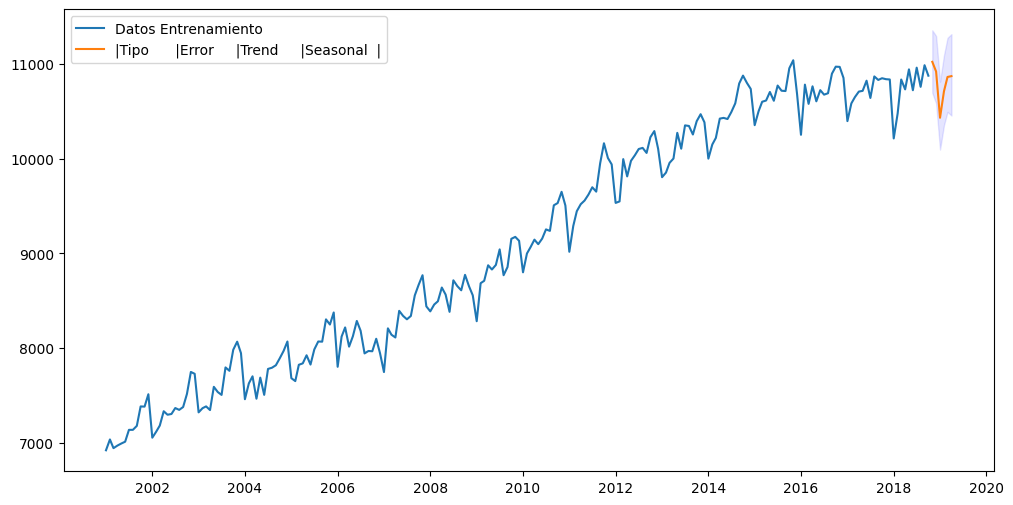

|Winters   |Mul       |Add       |Mul       |
+----------+----------+----------+----------+


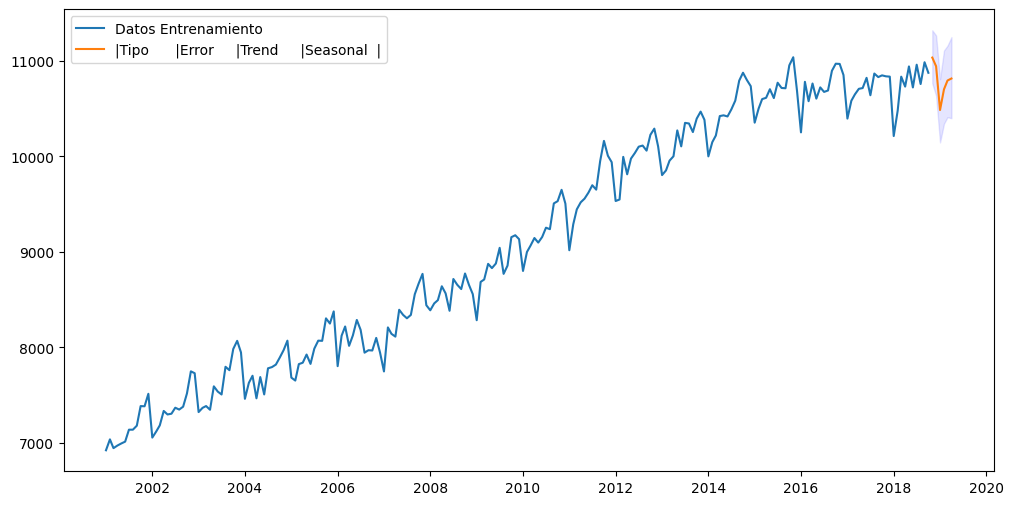

|Holt      |Mul       |Add       |None      |
+----------+----------+----------+----------+


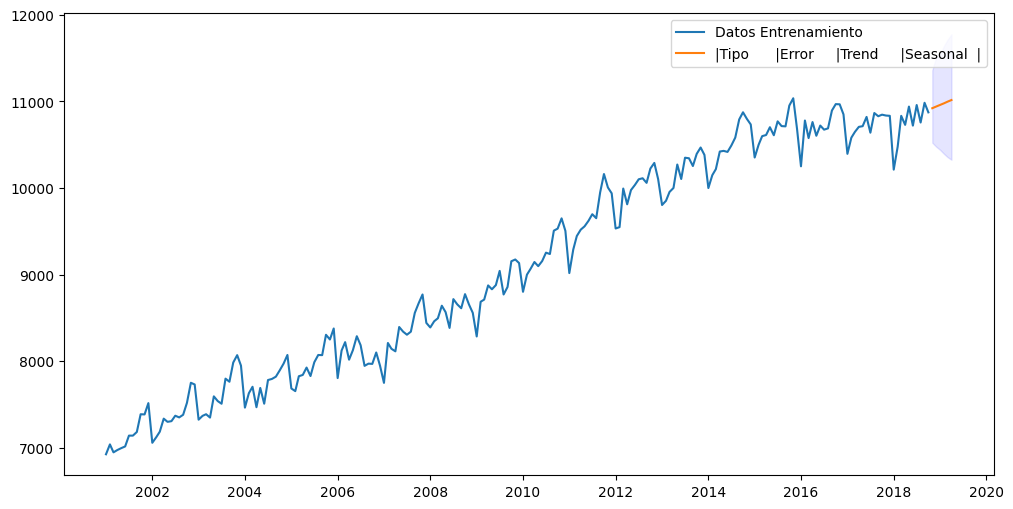

|Winters   |Mul       |Mul       |Add       |
+----------+----------+----------+----------+


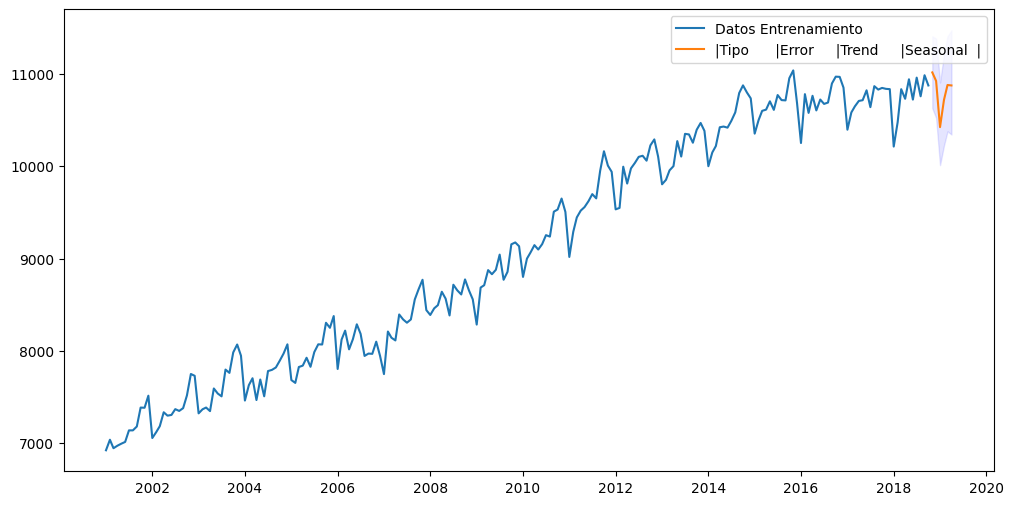

|Winters   |Mul       |Mul       |Mul       |
+----------+----------+----------+----------+


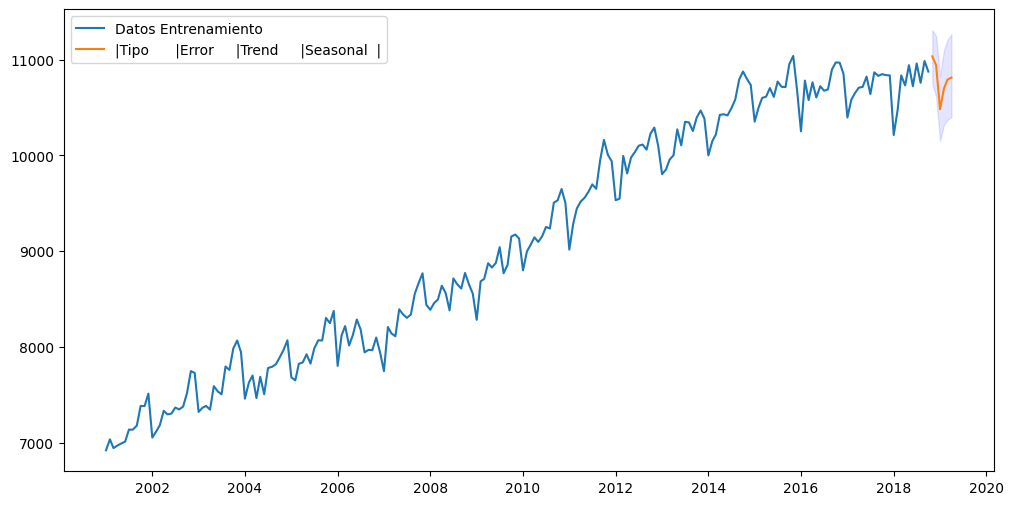

|Holt      |Mul       |Mul       |None      |
+----------+----------+----------+----------+


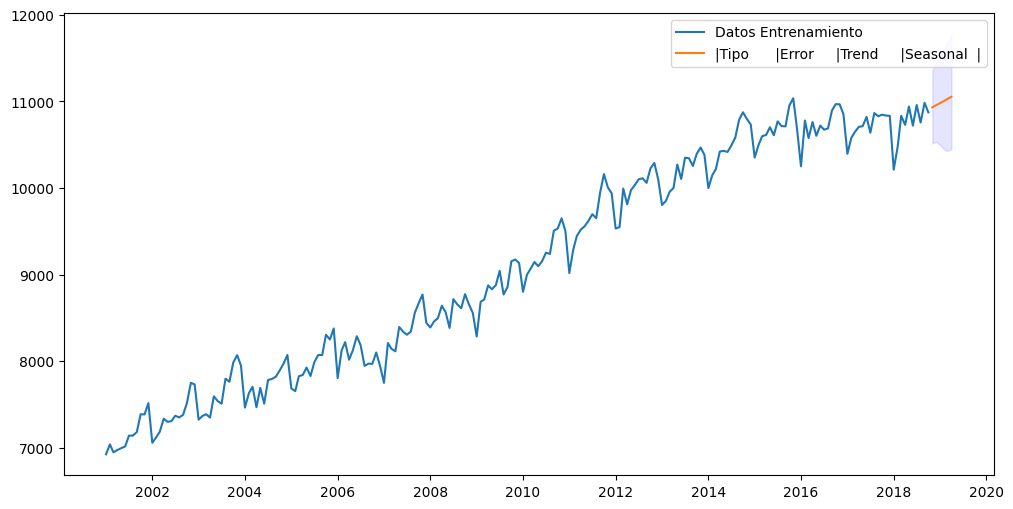

|Winters   |Mul       |None      |Add       |
+----------+----------+----------+----------+


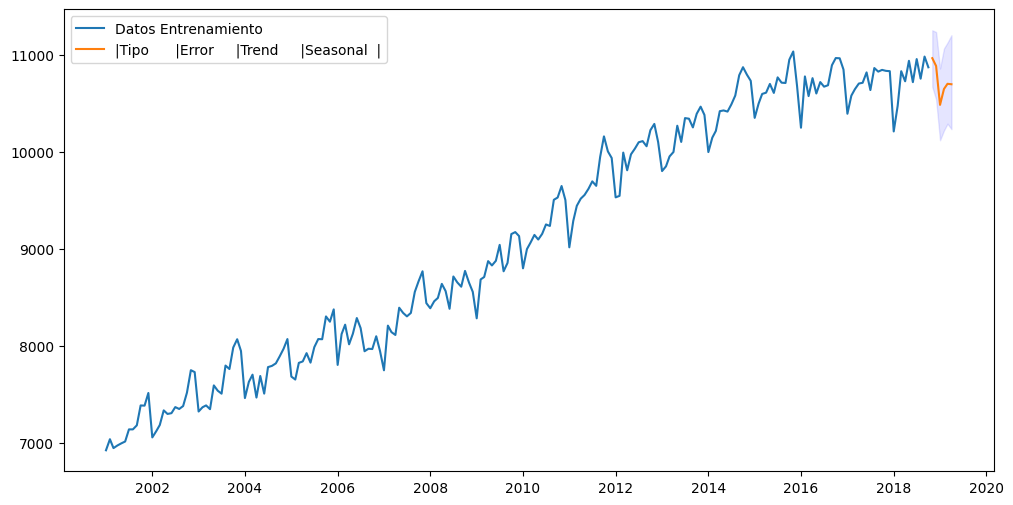

|Winters   |Mul       |None      |Mul       |
+----------+----------+----------+----------+


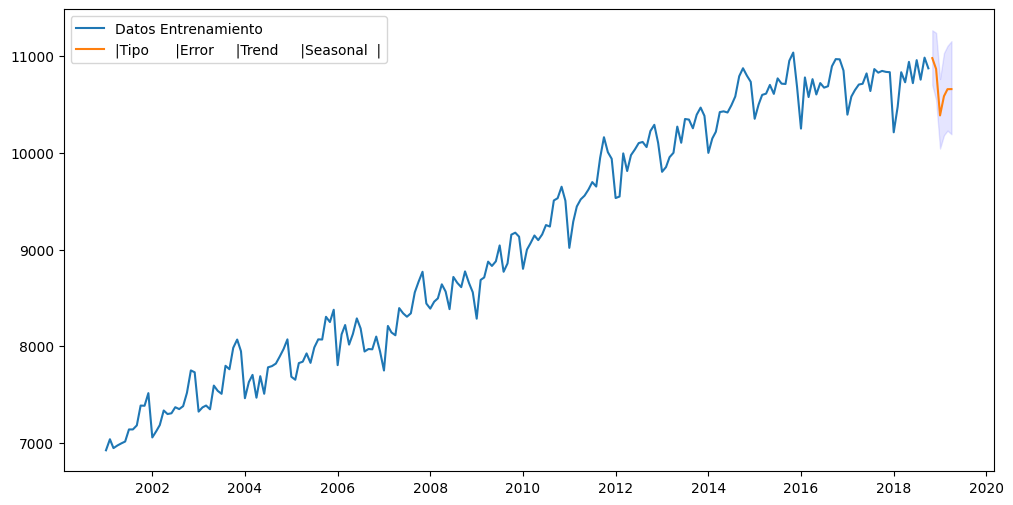

|Simple    |Mul       |None      |None      |
+----------+----------+----------+----------+


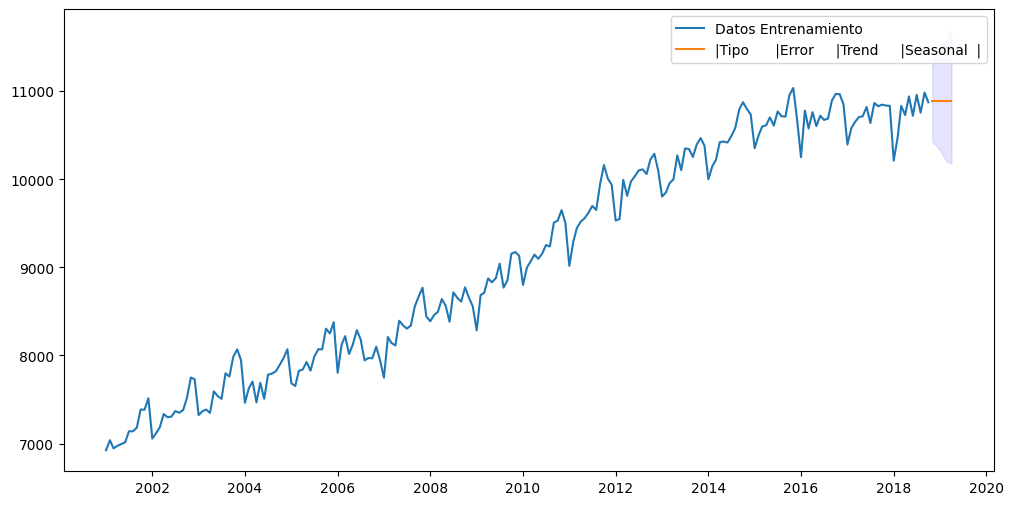

|Winters   |None      |Add       |Add       |
+----------+----------+----------+----------+


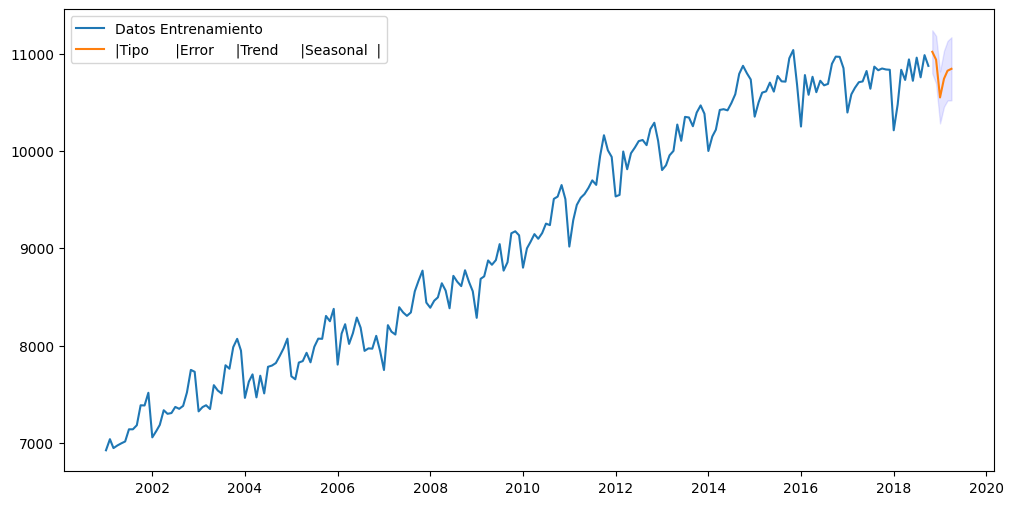

|Winters   |None      |Add       |Mul       |
+----------+----------+----------+----------+


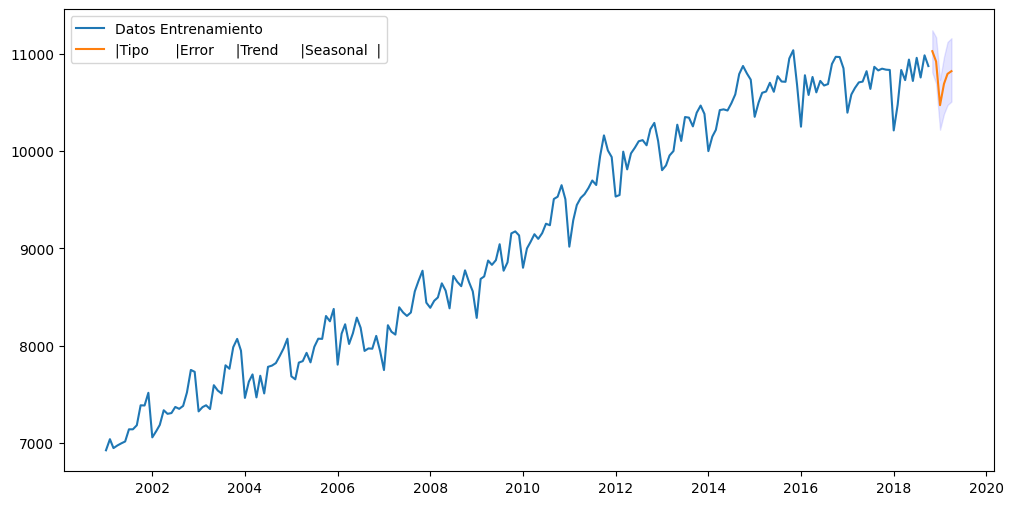

|Holt      |None      |Add       |None      |
+----------+----------+----------+----------+


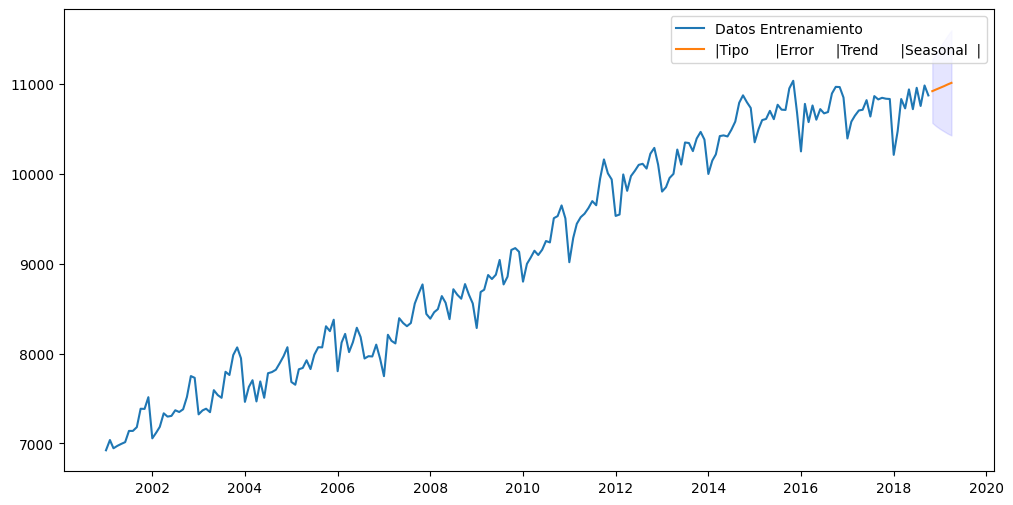

|Winters   |None      |Mul       |Add       |
+----------+----------+----------+----------+


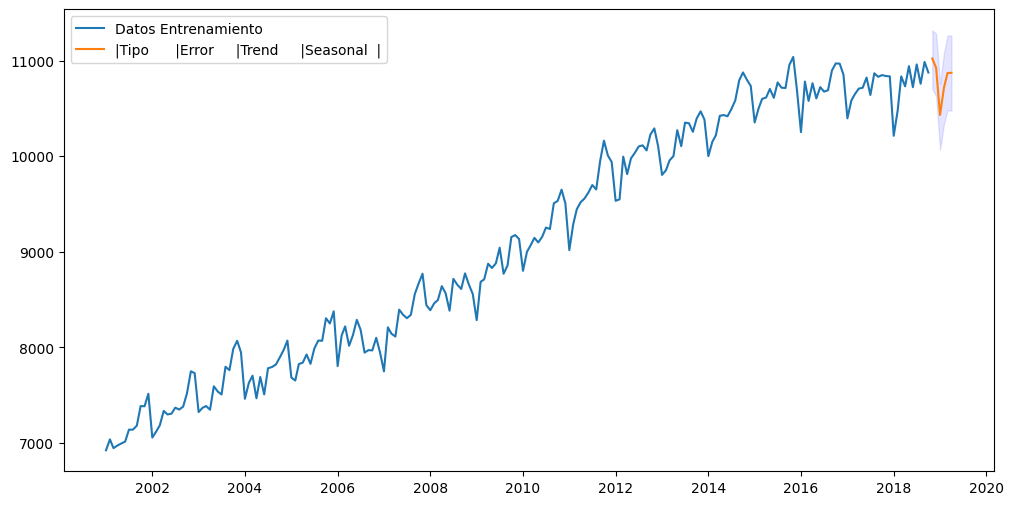

|Winters   |None      |Mul       |Mul       |
+----------+----------+----------+----------+


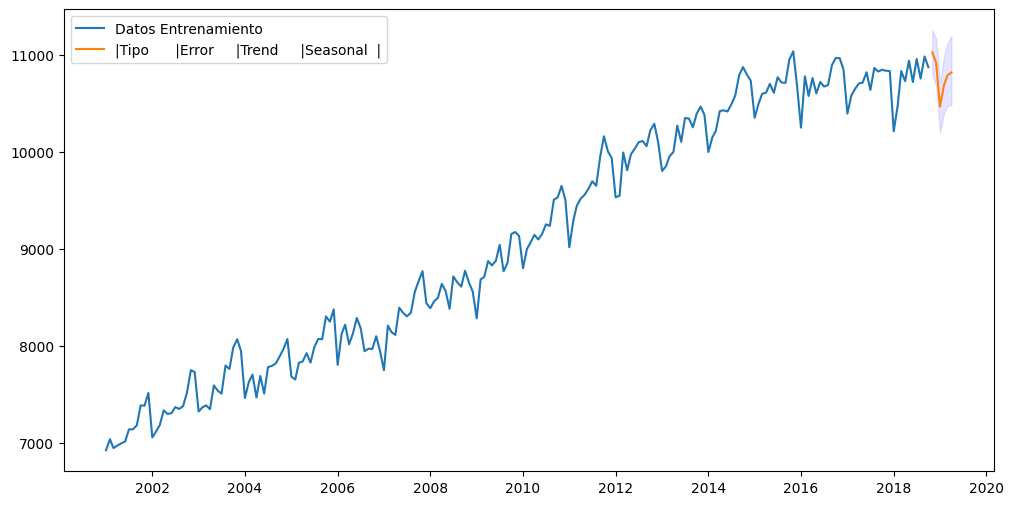

|Holt      |None      |Mul       |None      |
+----------+----------+----------+----------+


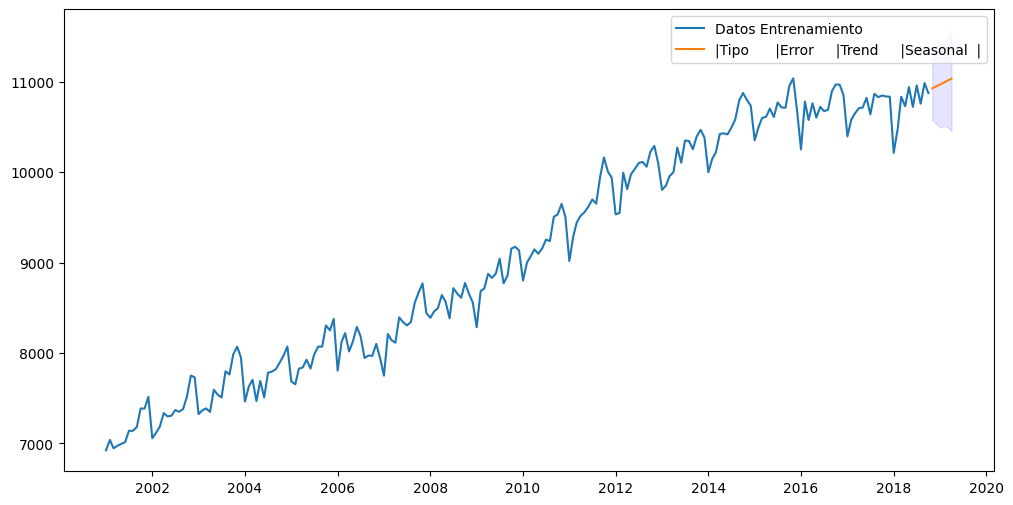

|Winters   |None      |None      |Add       |
+----------+----------+----------+----------+


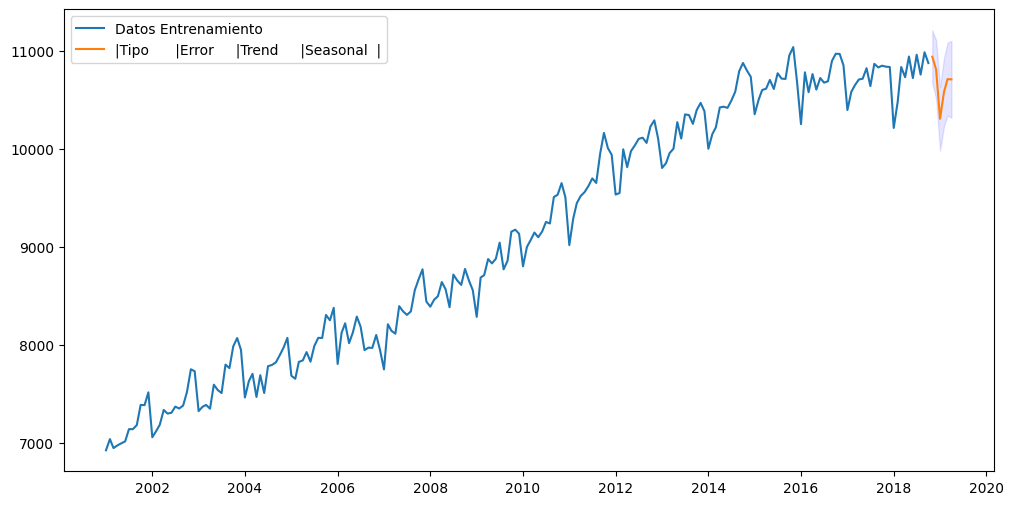

|Winters   |None      |None      |Mul       |
+----------+----------+----------+----------+


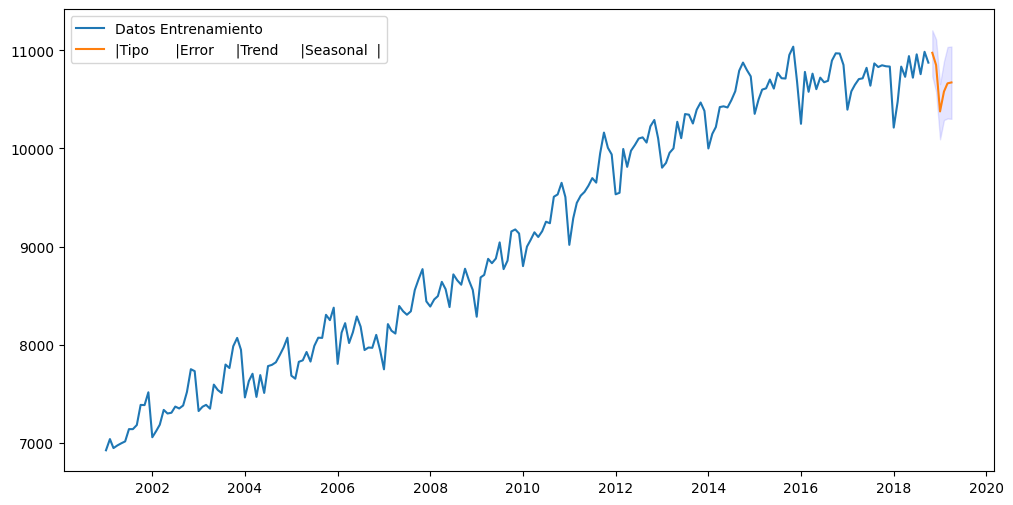

In [27]:
print('Procesando...')

print("+----------+----------+----------+----------+")
print("+ Tipo     + Error    + Tred     + Seasonal +")
print("+----------+----------+----------+----------+")

for index, item in df.iterrows():
  item['Alpha'], item['Beta'], item['Gamma'], item['RMSE'] = calculo(train_Ocupados, item['Tipo'], item['Error'], item['Trend'], item['Seasonal'])


In [28]:
df

,Tipo,Error,Trend,Seasonal,Alpha,Beta,Gamma,RMSE
0,Winters,Add,Add,Add,0.478508,0.000048,0.000052,184.603576
1,Winters,Add,Add,Mul,0.513366,0.001316,0.000049,156.414583
2,Holt,Add,Add,None,0.571964,0.006149,,370.15798
3,Winters,Add,Mul,Add,0.388738,0.000039,0.337249,169.239005
4,Winters,Add,Mul,Mul,0.51365,0.000051,0.000049,154.826727
5,Holt,Add,Mul,None,0.545041,0.000055,,381.545884
6,Winters,Add,None,Add,0.472896,,0.299601,74.992571
7,Winters,Add,None,Mul,0.595513,,0.00004,93.497548
8,Simple,Add,None,None,0.634303,,,300.429031
9,Winters,Mul,Add,Add,0.348934,0.000035,0.326168,166.43548


In [29]:
df_sorted = df.sort_values('RMSE')
df_sorted

,Tipo,Error,Trend,Seasonal,Alpha,Beta,Gamma,RMSE
6,Winters,Add,None,Add,0.472896,,0.299601,74.992571
24,Winters,None,None,Add,0.472896,,0.299601,74.992571
25,Winters,None,None,Mul,0.595513,,0.00004,93.497548
7,Winters,Add,None,Mul,0.595513,,0.00004,93.497548
16,Winters,Mul,None,Mul,0.623237,,0.000038,97.452404
15,Winters,Mul,None,Add,0.612584,,0.000039,117.565114
22,Winters,None,Mul,Mul,0.51365,0.000051,0.000049,154.826727
4,Winters,Add,Mul,Mul,0.51365,0.000051,0.000049,154.826727
1,Winters,Add,Add,Mul,0.513366,0.001316,0.000049,156.414583
19,Winters,None,Add,Mul,0.513366,0.001316,0.000049,156.414583
